normal
 circle 
 spiral
Model - poly features
  loss function
Desicion boundary - line, fill

binary_classification
multiclass

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import seaborn as sns

In [2]:
plt.set_cmap('RdBu')

<Figure size 432x288 with 0 Axes>

In [3]:
np.set_printoptions(threshold=10)
sigmoid = lambda x : 1 / (1 + np.exp(-x))

## Generating Bivariate Classification Data

In [4]:
def generate_classification_data(size, classes=2, angle=None, sep=1, noise=1, n_features=2):
    means = np.linspace(-sep, sep, classes) * classes
    X = np.concatenate([np.random.normal(loc=means[i], 
                                         scale=noise, 
                                         size=(size // classes, n_features)) for i in range(classes)], axis=0)
    y = np.concatenate([np.zeros(size // classes) + i for i in range(classes)], axis=0)
    angle = angle if angle else np.random.randint(0, 181)
    theta = np.pi / 180 * angle
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    X = X @ R
    return X, y

In [5]:
X, y = generate_classification_data(500)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (400, 2)
X_test shape :  (100, 2)
y_train shape :  (400,)
y_test shape :  (100,)


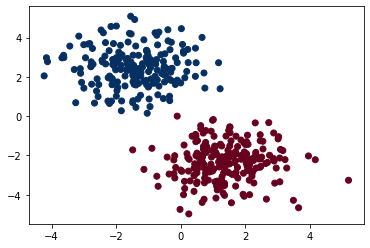

In [8]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

## Logistic Regression  Model

In [9]:
class LogisticRegressionClassifier:
    def __init__(self, n_features, weights=None, normalize=True, threshold=0.5):
        self.__n_features = n_features
        self.weights = weights if np.sum(weights) else np.random.randn(self.__n_features + 1) 
        self.__normalize = normalize
        self.__scaling_params = (0, 1)
        self.__threshold = threshold
        self.metrics = None
           
    def __transform(self, X):
        if self.__normalize:
            mu, s = self.__scaling_params
            X = (X - mu) / (s + 1e-9)
        return np.vstack([np.ones(X.shape[0]), X.T])
        
    def fit(self, X, y, epochs=1, batch_size=None, alpha=0.001, verbose=True):
        self.__scaling_params = (X.mean(axis=0), X.std(axis=0))
        X = self.__transform(X)
        loss_per_epochs, acc_per_epochs = [], []
        for i in range(epochs):
            y_pred = sigmoid(self.weights.T @ X)
            J = -np.mean(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))
            acc = np.mean((y_pred >= self.__threshold) == y)
            loss_per_epochs.append(J)
            acc_per_epochs.append(acc)
            self.weights -= alpha * np.mean((y_pred - y) * X, axis=1)            
            if verbose:
                print(f'Epoch {i+1}/{epochs}\n{X.shape[-1]}/{X.shape[-1]} [==============] : loss = {J:.6f}\t acc = {acc}')
        self.metrics= {'loss_per_epochs' : loss_per_epochs, 'acc_per_epochs' : acc_per_epochs}
        
    def predict(self, X, predict_classes=False):
        y_pred = sigmoid(self.weights.T @ self.__transform(X))
        if predict_classes:
            y_pred = y_pred >= self.__threshold
        return y_pred
    
    def evaluate(self, X, y, return_preds=False):
        y_pred = self.predict(X)
        J = -np.mean(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))
        acc = np.mean((y_pred >= self.__threshold) == y)
        evaluation = {'loss' : J, 'accurracy' : acc}
        if return_preds:
            evaluation['predictions'] = y_pred
        return evaluation
    
    def get_weights(self, return_scaling_params=False):
        """returns weights as a dict object with keys - `weights` and `bias`"""
        model_weights = {'weights' : self.weights[1:], 'bias' : self.weights[0]}
        if return_scaling_params:
            model_weights['scaling_mean'], model_weights['scaling_std'] = self.__scaling_params
        return model_weights 

## Training

In [10]:
model = LogisticRegressionClassifier(n_features=2)

In [11]:
model.fit(X_train, y_train, epochs=10, alpha=1)

Epoch 1/10
400/400 [==============] : loss = 1.340879	 acc = 0.01
Epoch 2/10
400/400 [==============] : loss = 0.645191	 acc = 0.635
Epoch 3/10
400/400 [==============] : loss = 0.385178	 acc = 0.985
Epoch 4/10
400/400 [==============] : loss = 0.279738	 acc = 0.99
Epoch 5/10
400/400 [==============] : loss = 0.223506	 acc = 0.9925
Epoch 6/10
400/400 [==============] : loss = 0.188227	 acc = 0.9925
Epoch 7/10
400/400 [==============] : loss = 0.163831	 acc = 0.995
Epoch 8/10
400/400 [==============] : loss = 0.145847	 acc = 0.995
Epoch 9/10
400/400 [==============] : loss = 0.131976	 acc = 0.995
Epoch 10/10
400/400 [==============] : loss = 0.120914	 acc = 0.995


Text(0.5, 1.0, 'Training Accuracy')

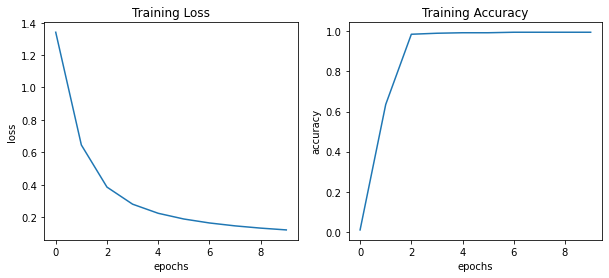

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(model.metrics['loss_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')
plt.subplot(122)
plt.plot(model.metrics['acc_per_epochs'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy')

In [13]:
min(model.metrics['loss_per_epochs'])

0.12091419858879444

In [14]:
model.get_weights()

{'weights': array([-1.40746732,  1.51906841]), 'bias': -0.16932101028449237}

## Evaluation

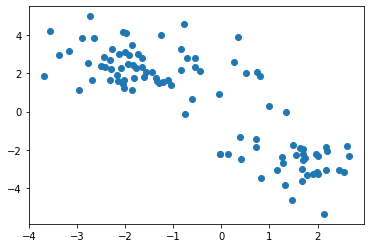

In [15]:
plt.scatter(X_test[:, 0], X_test[:, 1])

In [16]:
model.evaluate(X_test, y_test)

{'loss': 0.10637522154191976, 'accurracy': 0.99}

In [17]:
y_pred = model.predict(X_test, predict_classes=True)

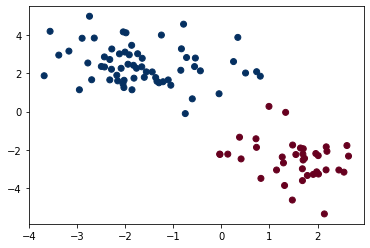

In [18]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

## Decision Boundary

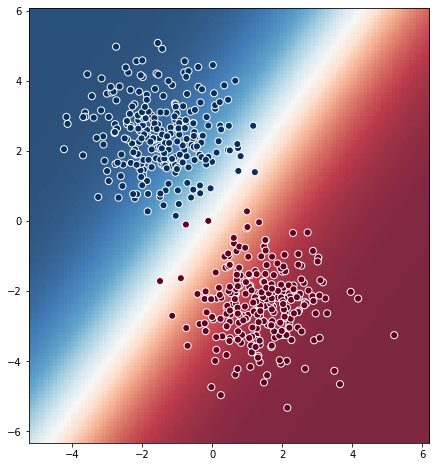

In [19]:
plt.figure(figsize=(8,8))
x1 = np.arange(X[:, 0].min() - 1, X[:, 0].max() + 1, 0.1)
x2 = np.arange(X[:, 1].min() - 1, X[:, 1].max() + 1, 0.1)

X1, X2 = np.meshgrid(x1, x2)
X1, X2 = X1.ravel(), X2.ravel() 
preds = model.predict(np.c_[X1, X2]).reshape(x2.shape[0], x1.shape[0])

extent=[X[:, 0].min() - 1, X[:, 0].max() + 1, X[:, 1].min() - 1, X[:, 1].max() + 1]
plt.imshow(preds, origin='lower', extent=extent, alpha=0.85)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='white', s=50)